<a href="https://colab.research.google.com/github/kmouts/PPS_Telemed/blob/main/heart_sound_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ανάλυση Ήχων Καρδιάς

Στο εργαστήριο αυτό θα ασχοληθούμε την Ανάλυση Ήχου, χρησιμοποιώντας μια νέα βιβλιοθήκη Python: **pyAudioAnalysis** [https://github.com/tyiannak/pyAudioAnalysis]. θα χρησιμοποιηθούν δεδομένα από μια Πρόκληση του 2011, ένα Δίκτυο Αριστείας υποστηριζόμενο από την Ευρωπαϊκή Ένωση (http://www.peterjbentley.com/heartchallenge/)

In [6]:
import requests, zipfile, io

r = requests.get( 'https://github.com/kmouts/PPS_Telemed/blob/main/heart.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [7]:
ls trainingData/

artifact/  extrah/  murmur/  normal/


Ας εγκαταστήσουμε τις βιβλιοθήκες του προγράμματος.

In [1]:
!git clone https://github.com/tyiannak/pyAudioAnalysis.git
!pip install -q -r pyAudioAnalysis/requirements.txt
!pip install -q -e pyAudioAnalysis/.

Cloning into 'pyAudioAnalysis'...
remote: Enumerating objects: 2529, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2529 (delta 2), reused 0 (delta 0), pack-reused 2523
Receiving objects: 100% (2529/2529), 156.02 MiB | 28.11 MiB/s, done.
Resolving deltas: 100% (1555/1555), done.
     |████████████████████████████████| 13.1MB 22.7MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 20.1MB 66.0MB/s 
     |████████████████████████████████| 153kB 47.6MB/s 
     |████████████████████████████████| 153kB 60.9MB/s 
     |████████████████████████████████| 6.8MB 51.2MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 7.1MB 53.3MB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompat

## Εξαγωγή χαρακτηριστικών

Υπάρχουν δύο στάδια στην μεθοδολογία εξαγωγής ηχητικών χαρακτηριστικών:


*   Εξαγωγή χαρακτηριστικών Μικρής Διάρκειας (Short-term): Γίνεται με τη χρήση της συνάρτησης `feature_extraction()` από το αρχείο `ShortTermFeatures.py`. Χωρίζει το εισαγόμενο σήμα σε μικρά χρονικά παράθυρα (frames) και υπολογίζει κάποια χαρακτηριστικά για το κάθε παράθυρο. Αυτή η διαδικασία οδηγεί σε μια σειρά από λίστες χαρακτηριστικών για όλο το σήμα
*   Εξαγωγή χαρακτηριστικών Μέσης Διάρκειας (Mid-term): Σε πολλές περιπτώσεις το σήμα αντιπροσωπεύεται από στατιστικές των χαρακτηριστικών μικρής διάρκειας. Η συνάρτηση `mid_feature_extraction()` από το αρχείο `MidTermFeatures.py` εξάγει στατιστικές (πχ μέση τιμή και τυπική απόκλιση) σε κάθε σειρά χαρακτηριστικών μικρής διάρκειας.


Το pyAudioAnalysis υποστηρίζει την εξαγωγή 34 χαρακτηριστικών (features) από αρχεία ήχου. Ας δούμε 2 από αυτά: **Zero Crossing Rate - ZCR** (The rate of sign-changes of the signal during the duration of a particular frame) και **Energy** (The sum of squares of the signal values, normalized by the respective frame length).

In [2]:
!apt-get install -qq ffmpeg
!apt-get install -qq python3-magic
!pip install -q python-magic

Selecting previously unselected package libmagic-mgc.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../libmagic-mgc_1%3a5.32-2ubuntu0.4_amd64.deb ...
Unpacking libmagic-mgc (1:5.32-2ubuntu0.4) ...
Selecting previously unselected package libmagic1:amd64.
Preparing to unpack .../libmagic1_1%3a5.32-2ubuntu0.4_amd64.deb ...
Unpacking libmagic1:amd64 (1:5.32-2ubuntu0.4) ...
Selecting previously unselected package python3-magic.
Preparing to unpack .../python3-magic_2%3a0.4.15-1_all.deb ...
Unpacking python3-magic (2:0.4.15-1) ...
Setting up libmagic-mgc (1:5.32-2ubuntu0.4) ...
Setting up libmagic1:amd64 (1:5.32-2ubuntu0.4) ...
Setting up python3-magic (2:0.4.15-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [3]:
import sys
sys.path.append('/content/pyAudioAnalysis')

In [12]:
ls -la /content/pyAudioAnalysis/pyAudioAnalysis

total 212
drwxr-xr-x 3 root root  4096 Apr 19 10:59 ./
drwxr-xr-x 6 root root  4096 Apr 19 11:00 ../
-rw-r--r-- 1 root root  2687 Apr 19 10:59 audacityAnnotation2WAVs.py
-rw-r--r-- 1 root root 29351 Apr 19 10:59 audioAnalysis.py
-rw-r--r-- 1 root root  5673 Apr 19 10:59 audioBasicIO.py
-rw-r--r-- 1 root root 46855 Apr 19 10:59 audioSegmentation.py
-rw-r--r-- 1 root root 48522 Apr 19 10:59 audioTrainTest.py
-rw-r--r-- 1 root root 10612 Apr 19 10:59 audioVisualization.py
-rw-r--r-- 1 root root   835 Apr 19 10:59 convertToWav.py
drwxr-xr-x 5 root root  4096 Apr 19 10:59 data/
-rw-r--r-- 1 root root     0 Apr 19 10:59 __init__.py
-rw-r--r-- 1 root root 15409 Apr 19 10:59 MidTermFeatures.py
-rw-r--r-- 1 root root 22586 Apr 19 10:59 ShortTermFeatures.py
-rw-r--r-- 1 root root  2464 Apr 19 10:59 utilities.py


In [11]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt


Για να διαβαστούν τα ηχητικά δείγματα καλούμε τη συνάρτηση `read_audio_file()` από το αρχείο `audioBasicIO.py`.



In [8]:
[Fs, x] = audioBasicIO.read_audio_file("trainingData//normal/normal_201101070538.wav")

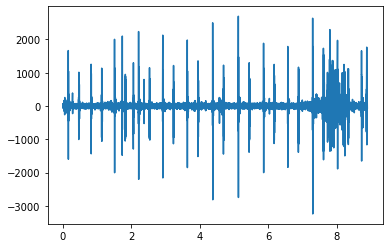

In [9]:
# Διάγραμμα με την κυματομορφή
import numpy
timeX = numpy.arange(0, x.shape[0] / float(Fs), 1.0 / Fs)
plt.plot(timeX, x)
plt.show()

Ο  επόμενος κώδικας χρησιμοποιεί τη συνάρτηση `feature_extraction()` από το αρχείο `ShortTermFeatures.py` για την εξαγωγή χαρακτηριστικών μικρής διάρκειας ενός ηχητικού σήματος. Θέτουμε χρονικό παράθυρο (frame) 50 msecs και βήμα 25 msecs (με 50% επικάλυψη).

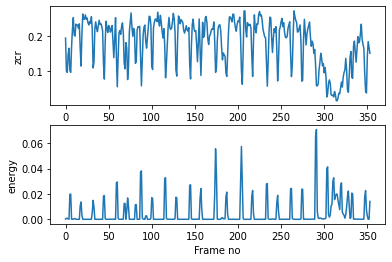

In [12]:
F, f_names = ShortTermFeatures.feature_extraction(x, Fs, 0.050*Fs, 0.025*Fs)
plt.subplot(2,1,1); plt.plot(F[0,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[0]) 
plt.subplot(2,1,2); plt.plot(F[1,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[1]); plt.show()

O παραπάνω κώδικας επίσης κάνει το διάγραμμα σειράς των δύο πρώτων χαρακτηριστικών: `zero crossing rate` και `signal energy`. Η συνάρτηση `feature_extraction()` επιστρέφει έναν πίνακα numpy  με 34 γραμμές και  N στήλες, όπου N το πλήθος των short-term frames που χωράνε στην εγγραφή του ήχου.

## Οπτική Ανάλυση του Ήχου

### Φασματικό Διάγραμμα

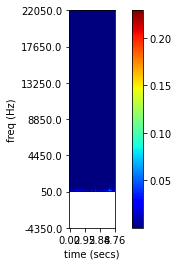

(221, 882)


In [13]:
[fs, x] = audioBasicIO.read_audio_file("trainingData/normal/normal_201101070538.wav")
x = audioBasicIO.stereo_to_mono(x)
specgram, TimeAxis, FreqAxis = ShortTermFeatures.spectrogram(x, fs, round(fs * 0.040),round(fs * 0.040), True)

### Χρωματικό Διάγραμμα

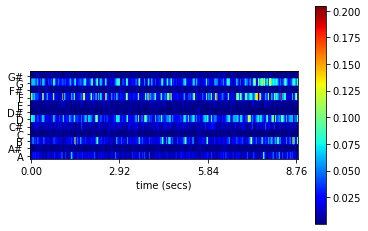

In [14]:
specgram, TimeAxis, FreqAxis = ShortTermFeatures.chromagram(x, fs, round(fs * 0.040),
                                                 round(fs * 0.040), True)

## Εκπαίδευση ενός Ταξινομητή Ήχου


Στην συνέχεια θα εκπαιδεύσουμε έναν ταξινομητή που χρησιμοποιεί Cross-Validation για να διαλέξει την βέλτιστη παράμετρο για τον ταξινομητή (πχ τη παράμετρο soft margin C για SVM, το πλήθος των δέντρων για Random Forests, ο αριθμός των γειτόνων k για Knn κλπ.) Το παραγόμενο μοντέλο σώζεται στη θέση που ορίζουμε με την παράμετρο –o.

Πρώτα όμως ας φορτώσουμε τα αρχεία εκπαίδευσης, και τα αρχεία για το τελικό τέστ.

In [ ]:
import requests, zipfile, io

r = requests.get( 'https://github.com/kmouts/PPS_MultiComms/blob/master/AudioAnaysisData.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
ls sampleData/

In [ ]:
ls trainingData/

In [ ]:
!mkdir models

In [ ]:
!python pyAudioAnalysis/pyAudioAnalysis/audioAnalysis.py trainClassifier -i trainingData/cat/ trainingData/dog/ --method svm -o models/svmSM

In [ ]:
%ls -la models/

### Ταξινόμηση ‘άγνωστων’ ήχων

Ας δούμε τώρα πόσο καλά τα πάει ο ταξινομητής μας:

In [ ]:
!python pyAudioAnalysis/pyAudioAnalysis/audioAnalysis.py classifyFolder -i sampleData/ --model svm --classifier models/svmSM --details



## Αφαίρεση σιγής

Η συνάρτηση `silence_removal()` από το αρχείο `audioSegmentation.py` παίρνει σαν είσοδο ένα αρχείο ηχογράφησης και εξάγει τμήματα που αντιστοιχούν σε ηχητικά γεγονότα. Με αυτό το τρόπο, τμήματα "σιγής" αφαιρούνται από το σήμα.

Αυτό επιτυγχάνεται με μια ημι-εποπτευόμενη (semi-supervised) προσέγγιση: Πρώτα εκπαιδεύεται ένα SVM μοντέλο στο να διακρίνει frames υψηλής/χαμηλής ενέργειας. Για το σκοπό αυτό γίνεται χρήση των 10% των υψηλότερων και 10% των χαμηλότερων ενεργειακά πλαισίων. Το παραγόμενο μοντέλο τρέχει σε όλο το αρχείο (με έξοδο την πιθανότητα) και με δυναμική κατωφλίωση (επιλογή –weight) για  να διακρίνει τα ενεργά τμήματα.

Η συνάρτηση `silence_removal()` έχει τα ακόλουθα ορίσματα: το σήμα, συχνότητα δειγματοληψίας, μήκος και βήμα παραθύρου, το παράθυρο (σε δευτερόλεπτα) που θα χρησιμοποιηθεί για την ομαλοποίηση της SVM σειράς πιθανοτήτων, ένας αριθμός μεταξύ 0 και 1 που ορίζει πόσο "αυστηρή" είναι η κατωφλίωση και τέλος μια boolean μεταβλητή σχετική με τη σχεδίαση του αποτελέσματος. Ας δούμε ένα παράδειγμα:

In [ ]:
from pathlib import Path
inputFile = Path("trainingData/cat/cat_1.wav")
smoothingWindow = 0.9
weight = 0.6
!mkdir tmp

In [ ]:
    from pyAudioAnalysis import audioSegmentation as aS
    import scipy.io.wavfile as wavfile

    [fs, x] = audioBasicIO.read_audio_file(inputFile)
    segmentLimits = aS.silence_removal(x, fs, 0.05, 0.05,
                                       smoothingWindow, weight, True)
    for i, s in enumerate(segmentLimits):
        strOut = "tmp/{0:s}_{1:.3f}-{2:.3f}.wav".format(inputFile.name[0:-4], s[0], s[1])
        wavfile.write(strOut, fs, x[int(fs * s[0]):int(fs * s[1])])

In [ ]:
!ls /tmp

Ανάλογα με το είδος της ηχογράφησης, θα πρέπει να χρησιμοποιηθούν διαφορετικές τιμές στο μήκος παραθύρου ομαλοποίησης και στο βάρος πιθανότητας. Πχ (1.0, 0.3) για ήχους που έχουν ανάμεσα μεγάλα διαστήματα σιγής. Για μια ηχογράφηση συνεχής ομιλίας (πχ count2.wav), θα πρέπει να χρησιμοποιηθεί μικρότερο παράθυρο και αυστηρότερο κατώφλι, πχ (0.1, 0.6)

## Απεικόνιση ομοιότητας ήχων

Η επόμενη λειτουργία εξάγει τα χαρακτηριστικά μεγάλης διάρκειας από αρχεία ήχων, εφαρμόζει τεχνική μείωσης διαστάσεων (dimensionality reduction) με PCA ή LDA (που είναι μια εποπτευόμενη [supervised] μέθοδος). Οι κλάσεις -στη δεύτερη περίπτωση= λαμβάνονται από το όνομα των αρχείων. Κοιτάξτε τα ονόματα στον κατάλογο sampleData:

In [ ]:
!ls sampleData

Από τις μειωμένες διαστάσεις που προκύπτουν από την PCA/LDA, υπολογίζεται ένας πίνακας ομοιότητας και με κατωφλίωση προκύπτει ο γράφος ομοιότητας, που αναπαρίσταται σε ένα  διάγραμμα χορδών (chordial). 
Εδώ βλέπουμε το γράφο ομοιότητας σε δύο άξονες:

In [ ]:
from pyAudioAnalysis import audioVisualization as aV
aV.visualizeFeaturesFolder("sampleData/", "pca", "")

Κοιτάξτε το περιεχόμενο των καταλόγων visualization_* που δημιουργήθηκαν:

In [ ]:
# !rm -rf visualization*
!ls -la 

In [ ]:
# import IPython
# IPython.display.HTML(filename='visualization_Chordial/similarities.html')

In [ ]:
import shutil
shutil.make_archive("/tmp/chor", 'zip', "visualizationInitial_Chordial")

In [ ]:
from google.colab import files
files.download('/tmp/chor.zip')

## Coding Task

Η ακρίβεια του ταξινομητή που φτιάξαμε προηγουμένως δεν είναι ιδιαίτερα καλή, στο περιορισμένο εύρος εκπαίδευσης που είχαμε διαθέσιμο. Μπορείτε να φτιάξετε ένα πρόγραμμα σε python, που να εκμεταλλεύεται την Αφαίρεση Σιγής και να παράγει ένα μοντέλο με καλύτερες αποδόσεις;